This notebook explores how small changes (perturbations) to a text prompt affect the images generated by a Stable Diffusion model. It also uses a CLIP model to measure how visually similar the outputs are.

In [ ]:
!pip install diffusers transformers accelerate safetensors torchvision open_clip_torch nltk --quiet

In [ ]:
import torch
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt
from PIL import Image
import random
import open_clip
from torchvision import transforms
import nltk
from nltk.corpus import wordnet
import numpy as np


Preparing the model

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


In [ ]:
# Download NLTK data for synonym replacement
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:

# Load Stable Diffusion model
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16 if device == "cuda" else torch.float32,
).to(device)

pipe.enable_attention_slicing()

# Load CLIP model for similarity comparison
clip_model, _, clip_preprocess = open_clip.create_model_and_transforms(
    'ViT-B-32', pretrained='laion2b_s34b_b79k'
)
clip_model = clip_model.to(device).eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
def change_one_letter(prompt):
    letters = 'abcdefghijklmnopqrstuvwxyz'
    idx = random.randint(0, len(prompt) - 1)
    while not prompt[idx].isalpha():
        idx = random.randint(0, len(prompt) - 1)
    orig_char = prompt[idx]
    new_char = random.choice([c for c in letters if c != orig_char.lower()])
    modified_prompt = prompt[:idx] + new_char + prompt[idx+1:]
    return modified_prompt, idx, orig_char, new_char

def replace_word_with_synonym(prompt):
    words = prompt.split()
    idx = random.randint(0, len(words) - 1)
    synonyms = wordnet.synsets(words[idx])
    if synonyms:
        lemma = synonyms[0].lemmas()[0].name().replace('_', ' ')
        words[idx] = lemma
    return ' '.join(words)

def add_nonsense_phrase(prompt):
    additions = ["riding spaghetti", "in a cloud of fish", "while it rains computers"]
    return prompt + " " + random.choice(additions)

In [ ]:
def get_clip_embedding(img):
    img = clip_preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        return clip_model.encode_image(img).float()

def compute_similarity(img1, img2):
    emb1 = get_clip_embedding(img1)
    emb2 = get_clip_embedding(img2)
    cosine_sim = torch.nn.functional.cosine_similarity(emb1, emb2).item()
    loss = 1 - cosine_sim
    return cosine_sim, loss

def show_images(img1, img2, title1="Original", title2="Modified"):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img1)
    axes[0].set_title(title1)
    axes[0].axis("off")
    axes[1].imshow(img2)
    axes[1].set_title(title2)
    axes[1].axis("off")
    plt.show()


#Giving prompt and pertuabtions

We use one original sentence and then create three versions of it by:

-Changing one letter

-Replacing one word with a synonym

-Adding a silly phrase to the end

Each perturbation modifies this prompt. Then we use Stable Diffusion to generate an images for each type to see the output of the model.


In [ ]:
base_prompt = "rabbit eating a spagetti"

modified_letter_prompt, idx, orig_char, new_char = change_one_letter(base_prompt)

perturbations = {
    "Letter Change": modified_letter_prompt,
    "Synonym Replace": replace_word_with_synonym(base_prompt),
    "Add Nonsense": add_nonsense_phrase(base_prompt),
}

original_img = pipe(base_prompt).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Perturbation Type: Letter Change
Modified Prompt:   rabbit eatgng a spagetti
CLIP Cosine Similarity: 0.7411
Simulated Perceptual Loss: 0.2589


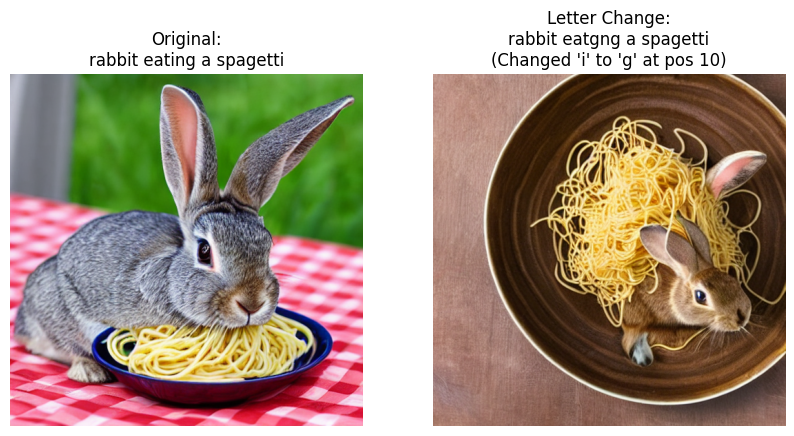

  0%|          | 0/50 [00:00<?, ?it/s]

Perturbation Type: Synonym Replace
Modified Prompt:   rabbit eating a spagetti
CLIP Cosine Similarity: 0.9084
Simulated Perceptual Loss: 0.0916


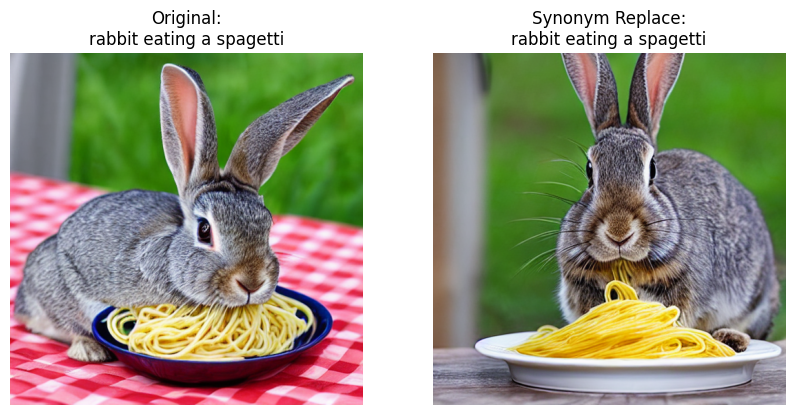

  0%|          | 0/50 [00:00<?, ?it/s]

Perturbation Type: Add Nonsense
Modified Prompt:   rabbit eating a spagetti while it rains computers
CLIP Cosine Similarity: 0.8226
Simulated Perceptual Loss: 0.1774


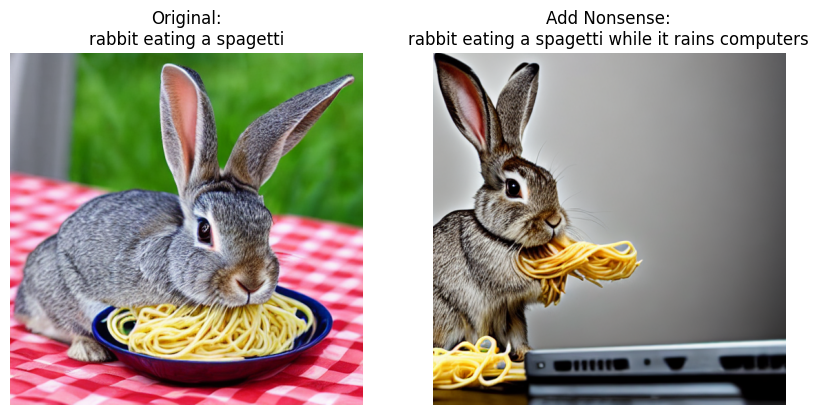

In [ ]:
#Attack
for perturbation_name, modified_prompt in perturbations.items():
    modified_img = pipe(modified_prompt).images[0]
    similarity, loss = compute_similarity(original_img, modified_img)

    print("Perturbation Type:", perturbation_name)
    print("Modified Prompt:  ", modified_prompt)
    print("CLIP Cosine Similarity: {:.4f}".format(similarity))
    print("Simulated Perceptual Loss: {:.4f}".format(loss))

    if perturbation_name == "Letter Change":
        title_original = f"Original:\n{base_prompt}"
        title_modified = (f"Letter Change:\n{modified_prompt}\n"
                          f"(Changed '{orig_char}' to '{new_char}' at pos {idx})")
    else:
        title_original = f"Original:\n{base_prompt}"
        title_modified = f"{perturbation_name}:\n{modified_prompt}"

    show_images(original_img, modified_img, title_original, title_modified)


This experiment shows that AI image generators can be very sensitive to the exact words used. Even a small change in the sentence can lead to big changes in the output image.